This project will take in a dataset and then predict the loss of the other 

### Imports and CUDA

In [22]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import os
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Loss Ratio is predicted as 

Loss Ratio=bytes_sent/bytes_retrans​

### Merging all the reno files

In [24]:
# folder_path = "reno"

# # Get a list of all CSV files in the folder
# csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# # Read and merge all CSV files
# df_list = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]

# # Concatenate all DataFrames
# merged_df = pd.concat(df_list, ignore_index=True)

# # Save the merged DataFrame to a new CSV file
# merged_df.to_csv(os.path.join(folder_path, "merged_reno.csv"), index=False)

# print("Merging complete. File saved as 'merged_output.csv'.")
# print("merged_reno.csv size: ", merged_df.shape)

# #And then move the file into the root directory

### Preparing the data

I need to normalize the data first, and the continue from there.

In [25]:

# Load dataset manually using NumPy
file_path = "./src/data/multi_tcp_20250411064307.csv"  # Update with actual file path
# Load the dataset using numpy (semicolon separated)
df = pd.read_csv(file_path, delimiter=";")  # skip_header=1 if there’s a header row

# remove last column, some kind of spacing i
# Drop the last column using pandas

# Convert "reno" -> 1 and "cubic" -> 0 in a new numeric column
df['tcp_type'] = df['tcp_type'].map({'reno': 1, 'cubic': 0})

# df['loss_ratio'] = (df['bytes_retrans'] / df['bytes_sent'])

# Identify constant columns
constant_columns = [col for col in df.columns if len(df[col].unique()) == 1]

constant_columns.append("bytes_retrans")
constant_columns.append("bytes_sent")

print("colunms without any variation: ", constant_columns)
# Drop constant columns from the dataset
df = df.drop(columns=constant_columns)

# Normalize using Min-Max scaling: (X - min) / (max - min)
data_min = df.min(axis=0)
data_max = df.max(axis=0)
df_normalized = (df - data_min) / (data_max - data_min)

# Now df_normalized is your dataset without the constant columns and normalized
print(df_normalized.iloc[0])

print(df_normalized.iloc[50])


df_normalized.to_csv("normalized.csv", index=False)  # Set index=False to exclude row numbers
# loss_ratio_tensor = torch.tensor(df['loss_ratio'].values, dtype=torch.float32)
# Convert to PyTorch tensor
#Changed df_normalized back to df first.
print(df_normalized.shape)

colunms without any variation:  ['wscale', 'mss', 'pmtu', 'rcvmss', 'advmss', 'delivered', 'rcv_space', 'rcv_ssthresh', 'bytes_retrans', 'bytes_sent']
rto              1.000000
rtt              1.000000
cwnd             0.181818
ssthresh         1.000000
bytes_acked      0.000000
segs_out         0.000000
segs_in          0.000000
data_segs_out    0.000000
lastrcv          0.000000
loss_ratio       1.000000
tcp_type         1.000000
timestamp        0.000000
Name: 0, dtype: float64
rto              0.000000
rtt              0.002542
cwnd             0.318182
ssthresh         0.000237
bytes_acked      0.051724
segs_out         0.051780
segs_in          0.052257
data_segs_out    0.051779
lastrcv          0.052789
loss_ratio       0.009229
tcp_type         0.000000
timestamp        0.053305
Name: 50, dtype: float64
(939, 12)


In [26]:
# df.to_csv("output.csv", index=False)  # Set index=False to exclude row numbers

In [27]:
#As stated in the paper
seq_length = 15
forecast_steps = 15  # Predict the next 15 seconds


def create_sequences(input, labels, seq_length, forecast_steps):
    xs, ys = [], []
    for i in range(len(input) - seq_length - forecast_steps + 1):
        xs.append(input[i : i + seq_length])  # Input sequence
        ys.append(labels[i + seq_length : i + seq_length + forecast_steps])  # Next `forecast_steps` values
    return np.array(xs), np.array(ys)


X, y = create_sequences(df_normalized.values, df_normalized['loss_ratio'].values, seq_length, forecast_steps)
data_tensor = torch.tensor(df.values, dtype=torch.float32)
new_X = torch.tensor(X,dtype=torch.float32)
new_y = torch.tensor(y[:,:, None], dtype=torch.float32)
print("Data tensor:", new_X.shape)
print("Loss tensor:", new_y.shape)

Data tensor: torch.Size([910, 15, 12])
Loss tensor: torch.Size([910, 15, 1])


### Splitting the data, 80/10/10

In [35]:
train_size = int(len(new_X) *0.8)
#I remove the first batch because it is just full of zeros,
X_train, X_test = new_X[:train_size], new_X[train_size:]
y_train, y_test = new_y[:train_size], new_y[train_size:]

# Print the shapes to verify the split
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 16  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Example of accessing a batch of data
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    
    break  # Only print the first batch for verification


torch.Size([728, 15, 12]) torch.Size([182, 15, 12])
torch.Size([728, 15, 1]) torch.Size([182, 15, 1])
Inputs: torch.Size([16, 15, 12]), Targets: torch.Size([16, 15, 1])


###LSTM Model used as the NN.

In [36]:
class LSTM_pt(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_pt, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # LSTM cell
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers = self.num_layers, batch_first = True)
        
        # Linear layer for final prediction
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, inputs, cell_state=None, hidden_state=None):
        # Forward pass through the LSTM cell
        if hidden_state is None or cell_state is None:
            hidden_state = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
            cell_state = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
        hidden = (cell_state, hidden_state)
        output, new_memory = self.lstm(inputs, hidden)
        cell_state, hidden_state = new_memory
        output = self.linear(output)  # Linear layer on all time steps
        return output, cell_state, hidden_state, # Return correct order

### I will implement sliding window next time, but for now, it will only predict the next value.

In [37]:
def train(model, dataloader, num_epochs, learning_rate):
    # Set the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()  # Set the model to training mode
    loss_values = []

    for epoch in range(num_epochs):
        total_loss = 0  # Track total loss for averaging
        hidden_state, cell_state = None, None  # Reset hidden states for each epoch

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            if batch_idx == len(dataloader) - 1:  
                break  # Skip the last batch

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

            # Compute loss
            loss = criterion(output, targets)
            total_loss += loss.item()  # Sum up the loss for averaging

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Detach hidden states to prevent memory buildup
            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()

            # # Print some sample outputs periodically
            # if epoch % 50 == 0 and batch_idx % 50 == 0:
            #     print("Output Sample: ", output[1:5])

        # Print average loss for the epoch
        avg_loss = total_loss / len(dataloader)
        loss_values.append(avg_loss)
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')
    
    plt.plot(range(num_epochs), loss_values, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()


Epoch 1/200, Loss: 0.022005
Epoch 101/200, Loss: 0.000014


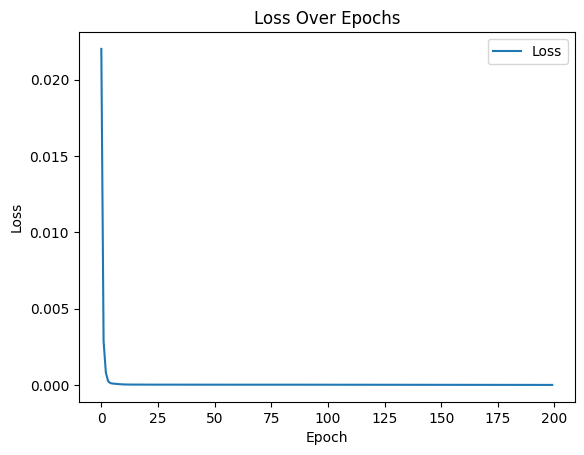

In [38]:
# Define the model parameters
# Following the research paper's instructions
input_size = 12
hidden_size = 20
num_layers = 1 # Can be changed to stack multiple LSTM layers!
output_size = 1
dataloader = train_loader

#Create the model
model = LSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
train(model, dataloader, num_epochs = 200, learning_rate = 0.001)


### Testing the model

In [39]:
for batch_idx, (inputs, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx}: Inputs Shape: {inputs.shape}, Targets Shape: {targets.shape}")

print("Total test batches:", len(test_loader))


Batch 0: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Batch 1: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Batch 2: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Batch 3: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Batch 4: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Batch 5: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Batch 6: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Batch 7: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Batch 8: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Batch 9: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Batch 10: Inputs Shape: torch.Size([16, 15, 12]), Targets Shape: torch.Size([16, 15, 1])
Total test batches: 11


Predicted output:  tensor([[8.6217e-06],
        [7.5603e-06],
        [7.1618e-06],
        [6.9903e-06],
        [6.9336e-06],
        [6.9226e-06],
        [6.8983e-06],
        [6.8861e-06],
        [6.8695e-06],
        [6.9160e-06],
        [6.8836e-06],
        [6.8837e-06],
        [6.8870e-06],
        [6.8945e-06],
        [6.8878e-06]])
True Output hello:  tensor([[6.8696e-06],
        [6.8735e-06],
        [6.8726e-06],
        [6.8689e-06],
        [6.8719e-06],
        [6.8673e-06],
        [6.8636e-06],
        [6.8596e-06],
        [6.8628e-06],
        [6.8621e-06],
        [6.8616e-06],
        [6.8604e-06],
        [6.8583e-06],
        [6.8496e-06],
        [6.8538e-06]])
Predicted output:  tensor([[6.9988e-06],
        [6.9946e-06],
        [6.9925e-06],
        [6.9902e-06],
        [6.9926e-06],
        [6.9559e-06],
        [6.9865e-06],
        [6.9891e-06],
        [6.9931e-06],
        [7.0154e-06],
        [7.0068e-06],
        [6.9944e-06],
        [6.9976e

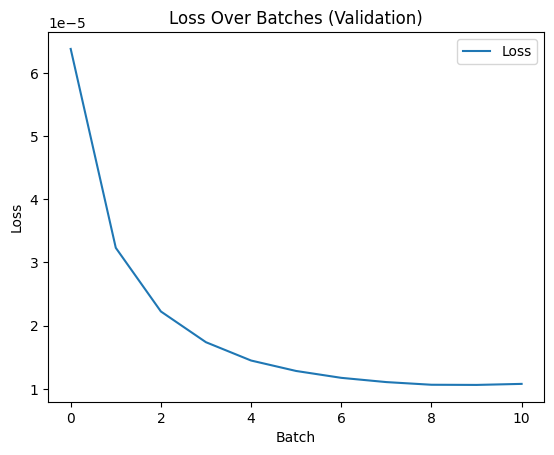

In [40]:

model.eval()

# Initialize variables to track loss
total_val_loss = 0
num_batches = 0
total_lost_values = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Initialize hidden state and cell state
hidden_state, cell_state = None, None  

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        # Initialize hidden state and cell state for each batch
        if hidden_state is not None:
            hidden_state = hidden_state.detach()
        if cell_state is not None:
            cell_state = cell_state.detach()

        # Forward pass
        output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

        output_denorm = output *(data_max["loss_ratio"] - data_min["loss_ratio"]) + data_min["loss_ratio"]
        target_denorm = targets *(data_max["loss_ratio"] - data_min["loss_ratio"]) + data_min["loss_ratio"]

        if batch_idx % 5 == 0:
            print("Predicted output: ", output_denorm[0])
            print("True Output hello: ", target_denorm[0])

        # Compute loss for this batch
        loss = criterion(output, targets)
        
        # Accumulate loss
        total_val_loss += loss.item()  # Add the batch loss to total
        total_lost_values.append(total_val_loss / (batch_idx + 1))  # Average loss so far
    
        num_batches += 1

# Compute average loss for the entire validation set
avg_loss = total_val_loss / num_batches

# Print validation results
print(f'Average Validation Loss: {avg_loss:.10f}')

# Plot the loss curve
plt.plot(range(num_batches), total_lost_values, label='Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss Over Batches (Validation)')
plt.legend()
plt.show()


In [34]:
print("output size", output.shape)
print("targets size", targets.shape)

output size torch.Size([8, 15, 1])
targets size torch.Size([8, 15, 1])


In [ ]:
# # Example raw input: [seq_len, num_features] (unnormalized)
# #To be used for algo
# raw_input = np.array([
#     [100, 0.5, 0.1],  # time step 1
#     [110, 0.6, 0.2],  # time step 2
#     [120, 0.7, 0.3],  # time step 3
# ], dtype=np.float32)

# # Normalize using your original Min-Max scalers
# normalized_input = (raw_input - data_min.values) / (data_max.values - data_min.values)
# normalized_input = torch.tensor(normalized_input, dtype=torch.float32).unsqueeze(0)  # [1, seq_len, num_features]

# model.eval()
# with torch.no_grad():
#     hidden_state, cell_state = None, None
#     output, _, _ = model(normalized_input, cell_state, hidden_state)

#     # Denormalize the output
#     min_val = data_min["Taxi Available in Selected Box Area"]
#     max_val = data_max["Taxi Available in Selected Box Area"]
#     output_denorm = output * (max_val - min_val) + min_val

#     print("Normalized model output:", output)
#     print("Denormalized prediction:", output_denorm)